In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from nltk.tokenize import TweetTokenizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import TruncatedSVD

data = pd.read_csv("sample_data_tweeter.csv")
list(data.columns.values)

['coordinates',
 'created_at',
 'hashtags',
 'media',
 'urls',
 'favorite_count',
 'id',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'lang',
 'place',
 'possibly_sensitive',
 'retweet_count',
 'reweet_id',
 'retweet_screen_name',
 'source',
 'text',
 'tweet_url',
 'user_created_at',
 'user_screen_name',
 'user_default_profile_image',
 'user_description',
 'user_favourites_count',
 'user_followers_count',
 'user_friends_count',
 'user_listed_count',
 'user_location',
 'user_name',
 'user_screen_name.1',
 'user_statuses_count',
 'user_time_zone',
 'user_urls',
 'user_verified']

In [2]:
data = data.loc[data["lang"] == "en"]
data

,coordinates,created_at,hashtags,media,urls,favorite_count,id,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,...,user_followers_count,user_friends_count,user_listed_count,user_location,user_name,user_screen_name.1,user_statuses_count,user_time_zone,user_urls,user_verified
1,NaN,Wed Apr 01 00:08:49 +0000 2020,Gravitas,NaN,NaN,0,1245141030132826112,NaN,NaN,NaN,...,67,377,1,"Dharwad, India",avinash,avinashbetdur,2389,NaN,NaN,False
2,NaN,Wed Apr 01 00:08:48 +0000 2020,NaN,NaN,https://dailycaller.com/2020/03/31/world-healt...,0,1245141025439354880,NaN,NaN,NaN,...,14,150,0,Inland NW,Ron Bleam,RonaldBleam,8135,NaN,NaN,False
3,NaN,Wed Apr 01 00:08:49 +0000 2020,lockdown,NaN,NaN,0,1245141029784780802,NaN,NaN,NaN,...,193,432,0,Kano,fLufferNutteR😘🤩,Maryermu,582,NaN,NaN,False
4,NaN,Wed Apr 01 00:08:49 +0000 2020,NaN,NaN,https://trib.al/28Et2dM,0,1245141030522896384,NaN,NaN,NaN,...,1396,1288,1,NaN,HK lover,Hongkon27195888,17238,NaN,NaN,False
5,NaN,Wed Apr 01 00:08:49 +0000 2020,NaN,NaN,NaN,0,1245141029650452481,NaN,NaN,NaN,...,247,454,10,☀Kingston ✈ATL-Twitterverse,D_Anne,Giselle_JA,22175,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41855,NaN,Wed Apr 01 00:58:02 +0000 2020,NaN,NaN,NaN,0,1245153415346323456,NaN,NaN,NaN,...,282,437,0,NaN,Shawn-C,SChristie1965,7841,NaN,NaN,False
41857,NaN,Wed Apr 01 00:58:02 +0000 2020,NaN,NaN,NaN,0,1245153415887372288,NaN,NaN,NaN,...,175,119,2,NaN,D🇵🇭,xoDonnellexo,12800,NaN,NaN,False
41862,NaN,Wed Apr 01 00:58:02 +0000 2020,COVIDIOT FakeNews,https://twitter.com/SJPFISH/status/12447694866...,NaN,0,1245153415543611395,NaN,NaN,NaN,...,79780,51313,52,"Baton Rouge, LA",𝑪𝒂𝒋𝒖𝒏♡𝑪𝒉𝒊𝒄𝒌™️🌷,cajun4trump,263777,NaN,NaN,False
41863,NaN,Wed Apr 01 00:58:02 +0000 2020,NaN,NaN,NaN,0,1245153415530975239,NaN,NaN,NaN,...,16579,10437,2,United States,🇺🇸🇮🇪Sassysoutherne3 🇮🇪🇺🇸,Sassysoutherne3,51690,NaN,NaN,False


In [3]:
genderData = pd.read_csv("gender-classifier-DFE-791531.csv",usecols=['gender', 'gender:confidence','description', 'text'], encoding='utf-8')
genderData['gender'] = genderData['gender'].astype(str)

In [4]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize.treebank import TreebankWordDetokenizer

stemmer = SnowballStemmer("english")
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def lemm(s):
    s = str(s)
    result = ''
    s = s.lower()    
    for token in gensim.utils.simple_preprocess(s):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result += ' ' + (lemmatize_stemming(token))
    return result

def normalize_text(s):
    s = str(s)
    s = s.lower()    
    # remove punctuation that is not word-internal (e.g., hyphens, apostrophes)
    s = re.sub('\s\W',' ',s)
    s = re.sub('\W\s',' ',s)
    
    # make sure we didn't introduce any double spaces
    s = re.sub('\s+',' ',s)
    return s

def tweet_token(s):
    s = str(s)
    replaced_urls = []  # Create an empty list
    replaced_mentions = []  # Create an empty list
    space = ' '
    tknzr = TweetTokenizer(strip_handles=True)
    tokens = tknzr.tokenize(s)
    tokens = [s for s in tokens if s.isascii()]
    return space.join(tokens)

In [5]:
# genderData['text_norm'] = [normalize_text(s) for s in genderData['text']]
# genderData['desc_norm'] = [normalize_text(s) for s in genderData['description']]
genderData['text_norm'] = [tweet_token(s) for s in genderData['text']]
genderData['desc_norm'] = [tweet_token(s) for s in genderData['description']]
genderData['descAndText'] = genderData['text_norm'] + genderData['desc_norm']
# genderData['descAndText'] = genderData['text_norm'].str.cat(genderData['desc_norm'], sep=' ')

In [6]:
useableGenderData = genderData[genderData['gender:confidence']==1]
useableGenderData = useableGenderData.drop(useableGenderData[useableGenderData.gender=='unknown'].index)
# useableGenderData = useableGenderData.drop(useableGenderData[useableGenderData.gender=='brand'].index)
# isMale = useableGenderData['gender'] == 'male'
# isFemale = useableGenderData['gender'] == 'female'
# useableGenderData = useableGenderData[isMale | isFemale]

In [7]:
print(useableGenderData['gender'].value_counts()/sum(useableGenderData['gender'].value_counts()))
useableGenderData.shape

female    0.388800
male      0.337076
brand     0.274123
Name: gender, dtype: float64


(13804, 7)

In [8]:
vectorizer = TfidfVectorizer(min_df=3)
x = vectorizer.fit_transform(useableGenderData['descAndText'])
encoder = LabelEncoder()
y = encoder.fit_transform(useableGenderData['gender'])

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, stratify=y, random_state = 4)

In [10]:
def eval_accuracy(model):
    model.fit(x_train, y_train)
    return model.score(x_test, y_test)

def pred_gender(model, tweetData, trainX, trainY):
    model.fit(trainX, trainY)
    return model.predict(tweetData)

In [11]:
models = [LogisticRegression(max_iter=1000),
          MultinomialNB(),
          RandomForestClassifier(n_estimators=100),
          KNeighborsClassifier(),
          SVC(),
          GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
          MLPClassifier(hidden_layer_sizes=(100,), learning_rate='adaptive'),
          SGDClassifier(loss="hinge", penalty="l2", max_iter=1000),
          LinearSVC(random_state=42)
         ]

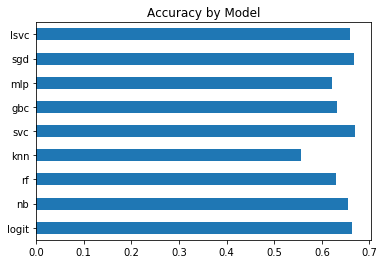

In [12]:
results = pd.Series([eval_accuracy(model) for model in models],
                    index = ["logit", 'nb', "rf", "knn", "svc", 'gbc', 'mlp', 'sgd','lsvc'])
results.plot(kind = "barh", title="Accuracy by Model")

In [13]:
model = LogisticRegression(max_iter=1000)
model.fit(x, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

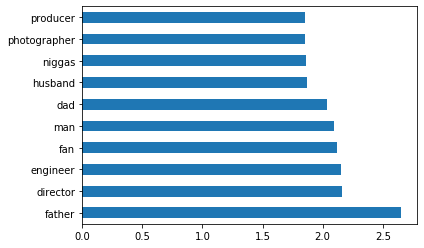

In [14]:
coeffs_male = pd.Series(model.coef_[2], index = vectorizer.get_feature_names())
coeffs_male.sort_values(ascending=False)[:10].plot.barh()

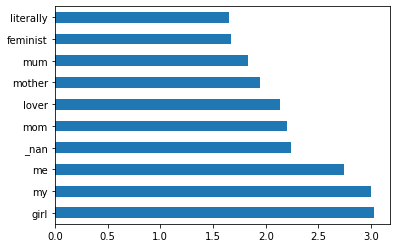

In [15]:
coeffs_female = pd.Series(model.coef_[1], index = vectorizer.get_feature_names())
coeffs_female.sort_values(ascending=False).head(10).plot.barh()

In [16]:
data['cleanedText'] = [tweet_token(s) for s in data['text']]
dataTweets = vectorizer.transform(data['cleanedText'])

models = [LogisticRegression(max_iter=1000),
          SGDClassifier(loss="hinge", penalty="l2", max_iter=1000),
          LinearSVC(random_state=42)
         ]
results = pd.Series([pred_gender(model, dataTweets, x, y) for model in models],
                    index = ["logit", 'sgd','lsvc'])

In [17]:
print(encoder.classes_)
results

['brand' 'female' 'male']


logit    [1, 2, 1, 1, 1, 2, 0, 1, 2, 1, 2, 2, 0, 2, 0, ...
sgd      [1, 0, 1, 1, 1, 2, 0, 1, 0, 1, 2, 2, 0, 2, 1, ...
lsvc     [1, 1, 1, 1, 1, 2, 0, 2, 0, 1, 2, 2, 0, 2, 1, ...
dtype: object

In [19]:
def tweet_token(s):
    s = str(s)
    replaced_urls = []  # Create an empty list
    replaced_mentions = []  # Create an empty list
    space = ' '
    tknzr = TweetTokenizer()
    tokens = tknzr.tokenize(s)
    tokens = [s for s in tokens if s.isascii()]
    for index, token in enumerate(tokens):
        # Replace URLs
        if token[0:8] == "https://":
            replaced_urls.append(token)
            tokens[index] = "<URLURL>"
            # ↳ *tokens[index]* will directly modify *tokens*, whereas any changes to *token* will be lost.

        # Replace mentions (Twitter handles; usernames)
        elif token[0] == "@" and len(token) > 1:
            # ↳ Skip the single '@' tokens
            replaced_mentions.append(token)
            tokens[index] = "<UsernameMention>"
    detokenizer = TreebankWordDetokenizer()
    processed_tweet = detokenizer.detokenize(tokens)
    return processed_tweet
    return space.join(tokens)

In [20]:
genderData = pd.read_csv("gender-classifier-DFE-791531.csv",usecols=['gender', 'gender:confidence','description', 'text'], encoding='utf-8')
genderData['gender'] = genderData['gender'].astype(str)
genderData['descAndText'] = genderData['text'] + genderData['description']
genderData['gender'] = genderData['gender'].values.astype('U')
genderData['descAndText'] = genderData['descAndText'].values.astype('U')
useableGenderData = genderData[genderData['gender:confidence']==1]
useableGenderData = useableGenderData.drop(useableGenderData[useableGenderData.gender=='unknown'].index)

In [21]:
tweetTrain, tweetTest, genderTrain, genderTest = train_test_split(useableGenderData['descAndText'], useableGenderData['gender'], test_size=0.1, stratify=useableGenderData['gender'], random_state = 4)

In [22]:
word_vectorizer = TfidfVectorizer(preprocessor=tweet_token,
                                  analyzer='word', ngram_range=(1,3),
                                  min_df=2, use_idf=True, sublinear_tf=True)
char_vectorizer = TfidfVectorizer(preprocessor=tweet_token,
                                 analyzer='char', ngram_range=(3, 5),
                                 min_df=2, use_idf=True, sublinear_tf=True)
ngrams_vectorizer = Pipeline([('feats', FeatureUnion([('word_ngram', word_vectorizer),
                                                     ('char_ngram', char_vectorizer),
                                                     ]))
                             ])
X_train_ngrams_tfidf = ngrams_vectorizer.fit_transform(tweetTrain)
feature_names_ngrams = [word_vectorizer.vocabulary_, char_vectorizer.vocabulary_]
X_test_ngrams_tfidf = ngrams_vectorizer.transform(tweetTest)
svd = TruncatedSVD(n_components=300, random_state=43)
X_train_ngrams_tfidf_reduced = svd.fit_transform(X_train_ngrams_tfidf)    
X_test_ngrams_tfidf_reduced = svd.transform(X_test_ngrams_tfidf)
x_train = X_train_ngrams_tfidf_reduced
x_test = X_test_ngrams_tfidf_reduced
clf = LinearSVC(random_state=42)

In [23]:
clf.fit(x_train, genderTrain)
clf.score(x_test,genderTest)

0.6227371469949312

In [25]:
X_train_ngrams_tfidf = ngrams_vectorizer.fit_transform(useableGenderData['descAndText'])
feature_names_ngrams = [word_vectorizer.vocabulary_, char_vectorizer.vocabulary_]
X_test_ngrams_tfidf = ngrams_vectorizer.transform(data['text'])
svd = TruncatedSVD(n_components=300, random_state=43)
X_train_ngrams_tfidf_reduced = svd.fit_transform(X_train_ngrams_tfidf)    
X_test_ngrams_tfidf_reduced = svd.transform(X_test_ngrams_tfidf)
x_train = X_train_ngrams_tfidf_reduced
x_test = X_test_ngrams_tfidf_reduced

In [26]:
models = [LogisticRegression(max_iter=1000),
          SGDClassifier(loss="hinge", penalty="l2", max_iter=1000),
          LinearSVC(random_state=42)
         ]
results = pd.Series([pred_gender(model, x_test, x_train, useableGenderData['gender']) for model in models],
                    index = ["logit", 'sgd','lsvc'])

In [27]:
results

logit    [male, male, female, male, male, female, male,...
sgd      [male, male, female, male, male, male, male, m...
lsvc     [male, male, female, male, male, female, male,...
dtype: object